# 단순한 딥러닝 구현
- 단순한 딥러닝을 구현해 손글씨 숫자를 식별할 수 있도록 학습시킨다.
- 전체 코드를 소개하기 전에 훈련용 손글씨 숫자 이미지와 코드의 중요한 부분을 먼저 살펴본다.

### 손글씨 숫자 이미지 데이터 확인
- 머신러닝 프레임워크인 사이킷런(scikit-learn)에는 몇 가지 학습용 데이터 세트가 준비되어 있다.
- 이번에는 그중에서 손글씨 숫자 이미지 데이터 세트를 읽어본다.

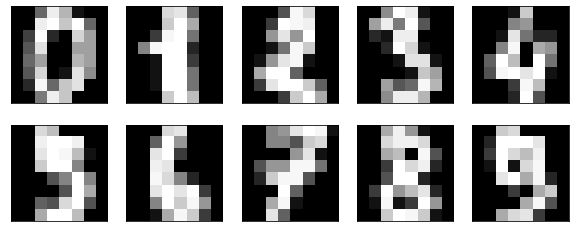

데이터 형태: (1797, 64)
레이블: [0 1 2 3 4 5 6 7 8 9]


In [1]:
## 손글씨 숫자 이미지 데이터 읽고 출력하기

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()

n_img = 10  # 출력할 이미지 개수
plt.figure(figsize=(10, 4))
for i in range(n_img):
    # 입력 이미지
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("데이터 형태:", digits_data.data.shape)
print("레이블:", digits_data.target[:n_img])

### 데이터 전처리
- 딥러닝에 적용하기 위해 입력과 정답 데이터를 표준화하고 원핫 인코딩(one-hot encoding)으로 변경한다.

In [ ]:
## 데이터 전처리
from sklearn.model_selection import train_test_split

# -- 입력 데이터 --
input_data = np.asarray(digits_data.data)
# 평균 0, 표준편차 1
input_data = (input_data - np.average(input_data)) / np.std(input_data)

# -- 정답 데이터 --
correct = np.asarray(digits_data.target)
correct_data = np.zeros((len(correct), n_out))
for i in range(len(correct)):
    correct_data[i, correct[i]] = 1 # 원핫 인코딩

# -- 훈련 데이터와 테스트 데이터로 분할
x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)

- 데이터를 asarray 함수로 처리하는 이유는 => GPU를 활용하기 위해서
- 사이킷런 데이터 세트는 GPU 활용을 고려하지 않기 때문에 GPU를 사용하려면 쿠파이(CuPy)의 배열로 변환해야 한다.
- 입력 데이터는 각 데이터에 평균값을 빼고 표준편차로 나누어 평균 0, 표준편차 1로 만든다.
- 정답 데이터 레이블은 원한 인코딩(one-hot encoding)으로 변환한다.
```
[0 0 1 0 .... 0 0]
```
- 원핫 인코딩은 하나의 값만 1이고 나머지는 모두 0
- 코드에서는 레이블이 표시된 부분이 1이고 나머지는 0이다.
- 입력과 정답 데이터를 훈련 데이터와 테스트 데이터로 분할한다.
- 사이킷런의 train_test_split 함수를 사용한다.
- train_test_split은 기본적으로 임의 추출한 25%의 데이터를 테스트 데이터에 할당하고 나머지 데이터를 훈련 데이터로 남겨둔다.

### 순전파와 역전파
- 각 층을 초기화해 리스트 형식으로 저장한다.
- 그다음 순전파와 역전파 함수와 파라미터 갱신을 위한 함수를 정의한다.

In [ ]:
## 여러 함수 정의

# -- 각 층의 초기화 --
layers = [MiddleLayer(img_size * img_size, n_mid), MiddleLayer(n_mid, n_mid), OutputLayer(n_mid, n_out)]

# -- 순전파 --
def forward_propagation(x):
    for layer in layers:
        layer.forward(x)
        x = layer.y
    return x

# -- 역전파 --
def backpropagation(t):
    grad_y = t
    for layer in reversed(layers):
        layer.backward(grad_y)
        grad_y = layer.grad_x
    return grad_y

# -- 파라미터 갱신 --
def update_params():
    for layer in layers:
        layer.update(eta)

- 층을 리스트로 저장해두면 for문으로 순전파와 역전파, 파라미터를 갱신하는 코드를 짧고 간단하게 작성할 수 있다.
- 역전파에서는 reversed 함수를 사용해 반복 처리 방향을 반대로 바꿀 수 있다.

### 미니 배치 구현
- 랜덤하게 미니 배치를 구성하고 순전파와 역전파, 파라미터 갱신을 실행한다.

In [ ]:
## 미니 배치 구현 코드
n_batch = len(x_train) // batch_size    # 1에포크당 배치 개수
for i in range(epochs):

    # -- 학습 --
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)     # 인덱스를 임의로 섞기
    for j in range(n_batch):

        # 미니 배치 구성
        mb_index = index_random[j * batch_size : (j+1) * batch_size]
        x_mb = x_train[mb_index, :]
        t_mb = t_train[mb_index, :]

        # 순전파와 역전파
        forward_propagation(x_mb)
        backpropagation(t_mb)

        # 파라미터 갱신
        update_params()

- 임의로 섞인 인덱스를 이용해 입력과 정답 쌍 데이터를 배치 사이즈만큼 임의 추출한다.
- 추출된 미니 배치를 사용해 순전파와 역전파를 실행하고 파라미터를 갱신한다.